# CPIT 440 lab manual - Lab 8 & 9
 
   ## Objective
   
   This lab aims to explore the following:
   1. MNIST dataset
   2. Binary classifier
   3. Performance measures
      1. accuracy
      2. confusion matrix
      3. precision and recall
      4. precision vs recall curve
      5. the ROC curve
   4. Multiclass classification
   5. Error analysis
   6. Evaluating on the test set


--------------------------------------

### 1. MNIST dataset

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. It is a set of 70,000 small images of digits handwritten by high school students and employees. Each image is labeled with the digit it represents.  
The following code fetches the MNIST dataset:

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784')  # Load data from https://www.openml.org/d/554
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:  
- A `DESCR` key describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
- A `target` key containing an array with the labels  

We will create the X and y of the dataset:

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
y = y.astype(np.float)  # This is because the labels of numbers are strings, so convert to float

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).  
We will view one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function.

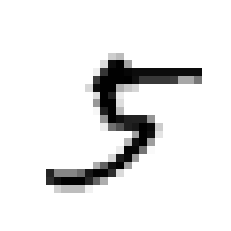

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36011]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [7]:
y[36011]

5.0

#### Spliting into train and test set
The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits).

In [9]:
np.random.seed(42)   # To get identical shuffle index at each run
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 2. Binary classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This **“5-detector”** will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task

In [10]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

We will select a classifier and train it. Let's start with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently.

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.  
Now you can use it to detect the number that represents an image.

**Case 1:**  
First, we will test the model on `some_digit` which was 5

In [12]:
sgd_clf.predict([some_digit])  #some_digit was 5

array([ True])

This is correct prediction.  
  
**Case 2:**  
Now, we will test the model on `X[36028]` which is 5

In [13]:
some_digit = X[36028]
sgd_clf.predict([some_digit])  #some_digit is 5

array([ True])

In [14]:
y[36028]

5.0

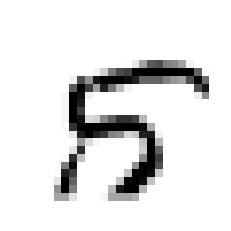

In [15]:
some_digit = X[36028]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This is also correct prediction.  
  
**Case 3:**  
Now, we will test the model on `X[36027]` which is 7

In [16]:
some_digit = X[36027]
sgd_clf.predict([some_digit])  #some_digit is 5

array([False])

In [17]:
y[36027]

7.0

It is correct prediction.

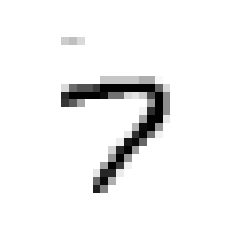

In [18]:
some_digit = X[36027]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

---------------------------------

### 3. Performance measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many methods to do the evaluation:
1. accuracy
2. confusion matrix
3. precision and recall
4. precision vs recall curve
5. the ROC curve

**3.1 accuracy**

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
scores

array([0.9681 , 0.95655, 0.95515])

As shown above, the accuracy (ratio of correct predictions) is above 95% in all the three folds. This is not because of the excellence of the model. Actually this is because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.  

The following cell shows the exact number of images that corresponds to each numerical digit.

In [20]:
unique, counts = np.unique(y, return_counts=True)

print(np.asarray((unique, counts)).T)

[[0.000e+00 6.903e+03]
 [1.000e+00 7.877e+03]
 [2.000e+00 6.990e+03]
 [3.000e+00 7.141e+03]
 [4.000e+00 6.824e+03]
 [5.000e+00 6.313e+03]
 [6.000e+00 6.876e+03]
 [7.000e+00 7.293e+03]
 [8.000e+00 6.825e+03]
 [9.000e+00 6.958e+03]]


This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

**3.2 Confusion Matrix**

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. Instead, you can use the `cross_val_predict()` function. Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a prediction for each instance in the training set. 

In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes `y_train_5` and the predicted classes `y_train_pred`:

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. 

The `confusion matrix` gives you a lot of information. An interesting one to look at is the accuracy of the positive predictions; this is called the `precision` of the classifier.  
  
precision = TP/(TP + FP)

precision is typically used along with another metric named `recall`, also called `sensitivity` or `true positive rate (TPR)`: this is the ratio of positive instances that are correctly detected by the classifier.  
  
recall = TP/(TP + FN)  
FN is the number of false negatives.

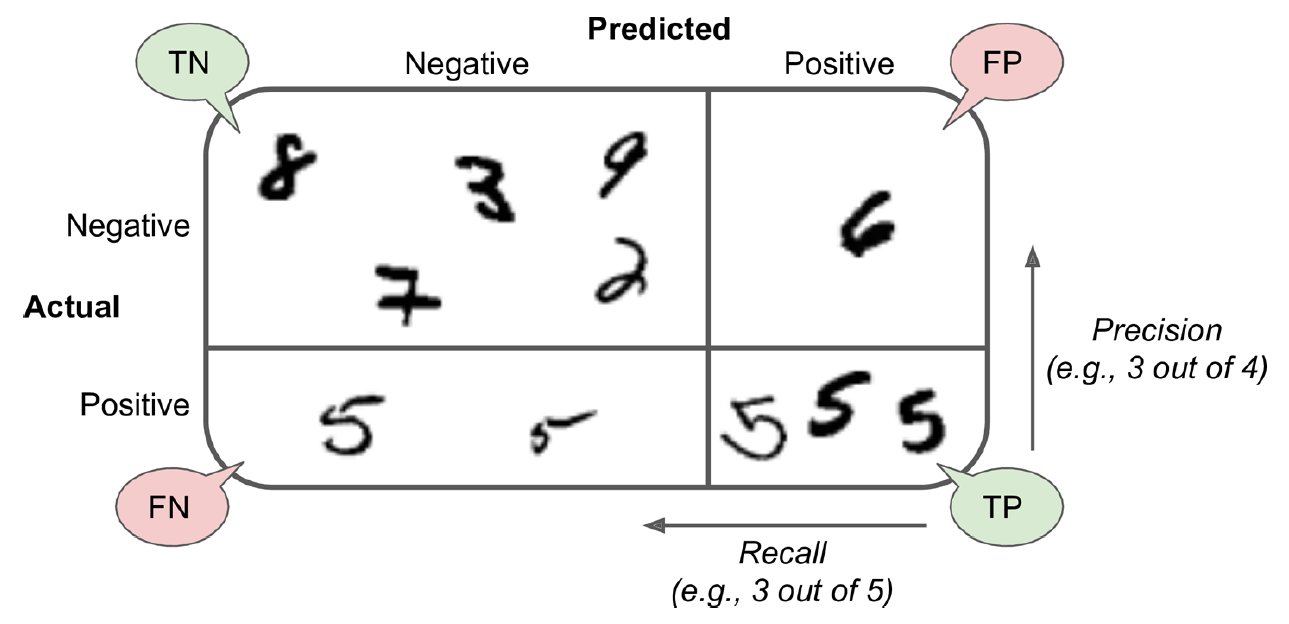

**3.3 Precision and Recall**

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.754513244474439

In [24]:
recall_score(y_train_5, y_train_pred)

0.8249400479616307

Now your **5-detector** does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 75% of the time. Moreover, it only detects 82% of the 5s.

To calculate the F1 score:

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7881565033486078

**3.4 precision vs recall curve**  

First we will plot the recall and precision vs many decision thresholds. You need to get the scores of all instances in the training set using the `cross_val_predict()` function again, but this time specifying that you want it to return decision scores instead of predictions. Then, the predictions are made based on those scores such that, when the decision score is higher than the threshold, the prediction is positive.

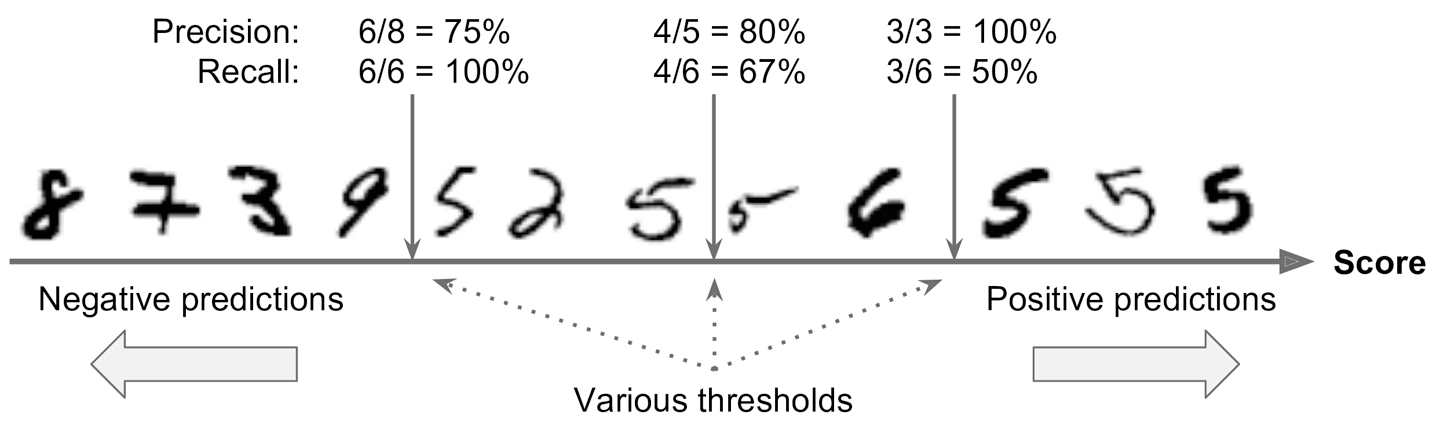

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function.

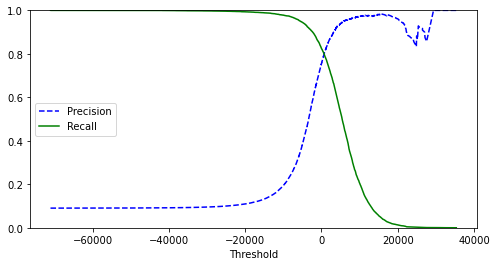

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

%matplotlib inline
import matplotlib.pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    #plt.xlim([-60000, 60000])
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task.  
Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

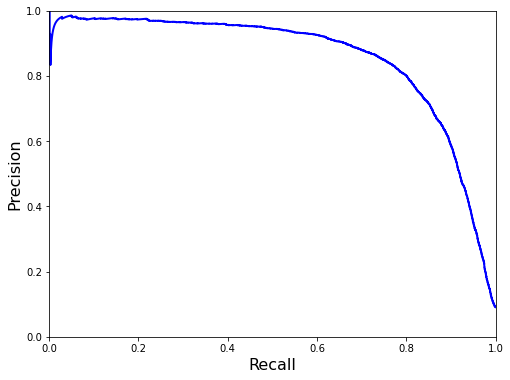

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.savefig('recall vs precision.png', dpi=300)
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around 60% recall. But of course the choice depends on your project.

**3.5 The ROC Curve**  

To plot the ROC curve, you first need to compute the true positive rate or recall (TPR) and the false positive rate i.e. (1-specificity) (FPR) for various threshold values, using the roc_curve() function:

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

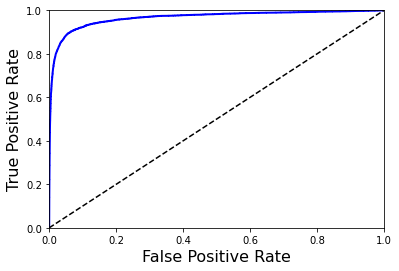

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr,"b-", linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

**Compare with RandomForestClassifier**  
Let’s train a `RandomForestClassifier` and compare its ROC curve to the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` class does not have a `decision_function()` method. Instead it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score:

In [32]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare.

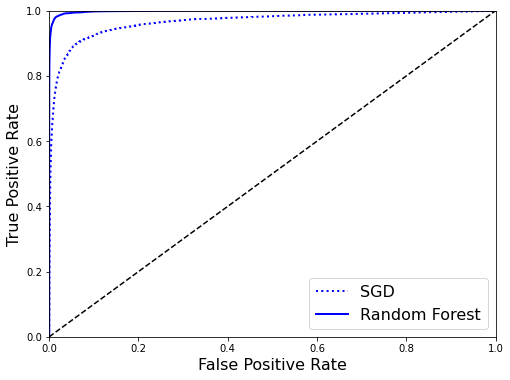

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

As you can see in the Figure, the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner.  
We can calculate its recall and precision as follwoing:

In [34]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9890893831305078

In [35]:
recall_score(y_train_5, y_train_pred_forest)

0.8695812580704667

These values are much better than the the SGDClassifier’s.

---------------------------------------

### 4. Multiclass classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers can distinguish between more than two classes.

Let's train another SGD classifier on the Mnist dataset to classify the digit images into 10
classes (from 0 to 9).

In [36]:
sgd_clf_multi = SGDClassifier(random_state=42)
sgd_clf_multi.fit(X_train, y_train) # y_train, not y_train_5
# test the classifier on some_digit
some_digit = X[36027]
sgd_clf_multi.predict([some_digit])

array([7.])

In [37]:
y[36027]

7.0

The classifier makes correct prediction in the case of `X[36027]`.  
Now of course you want to evaluate the classifier. We will use cross-validation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function.

In [38]:
cross_val_score(sgd_clf_multi, X_train, y_train, cv=3, scoring="accuracy")

array([0.8678 , 0.88195, 0.86965])

It gets over 86% on all test folds. This is not such a bad score, but you can still do much better. For example, simply scaling the inputs (z-score normalization) increases accuracy to approximately 90%:

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf_multi, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90425, 0.9031 , 0.8903 ])

Let's train a RandomForestClassifier, and test its prediction on `some_digit`:

In [40]:
forest_clf_multi = RandomForestClassifier(n_estimators=10, random_state=42)
forest_clf_multi.fit(X_train, y_train)
forest_clf_multi.predict([some_digit])

array([7.])

We will evaluate the RandomForestClassifier’s accuracy using the cross_val_score() function.

In [41]:
cross_val_score(forest_clf_multi, X_train, y_train, cv=3, scoring="accuracy")

array([0.94005, 0.943  , 0.94295])

As you can see, the RandomForestClassifier provides better accuracy than the SGDClassifier.

### 5. Error analysis

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.  
First, you can look at the confusion matrix. You need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function:

In [42]:
y_train_pred = cross_val_predict(forest_clf_multi, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5815,    1,   19,    9,    7,   14,   22,    3,   30,    3],
       [   2, 6618,   35,   19,   15,    9,   10,   14,   13,    7],
       [  52,   29, 5620,   62,   35,   19,   24,   53,   51,   13],
       [  21,   22,  127, 5669,    9,  108,   13,   55,   69,   38],
       [  22,   19,   27,    8, 5532,    8,   31,   14,   26,  155],
       [  43,   17,   24,  179,   32, 4980,   53,   10,   52,   31],
       [  38,   16,   25,    7,   30,   57, 5715,    0,   29,    1],
       [  11,   33,   81,   23,   71,    8,    1, 5945,   14,   78],
       [  37,   60,   93,  131,   54,  103,   47,   17, 5236,   73],
       [  28,   17,   43,   77,  181,   46,    9,   94,   61, 5393]],
      dtype=int64)

That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s `matshow()` function:

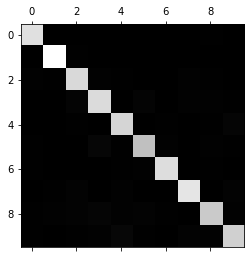

In [43]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most bright squares are on the main diagonal, which means that the digits' images were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors.

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [45]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:

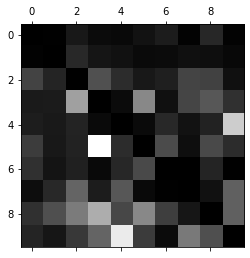

In [46]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes.  
It is clear that there is a confucion between 4 and 9 images. Also, there is confusion between 3 and 5 digits but it is not symmetric.  
The rows for classes 8 and 9 are quite bright, telling you that 8s and 9s are often confused with other digits. Similarly, the column for class 9 is quite bright, which tells you that many images get misclassified as 9s.  
Conversely, some rows are pretty dark, such as rows 0 and 1: this means that most 0s and 1s are classified correctly.  
Notice that the errors are not perfectly symmetrical; for example, there are more 3s misclassified as 2s than the reverse.  
Analyzing the confusion matrix can often give you insights on ways to improve your classifier. For example, you could try to gather more training data for the digits with more confusion.

### 6. Evaluating on the test set

Now we will evaluate the final model on the test set.  


In [47]:
final_predictions = forest_clf_multi.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, final_predictions)

0.9476

The classification accuracy on the test is 94%.